In [49]:
import numpy as np
import pandas as pd
from sklearn import linear_model, model_selection
from matplotlib import pyplot as plt
import scipy

In [2]:
# 读取上次保存的数据
model_data = pd.read_csv('./data/model_data.csv')
test_data = pd.read_csv('./data/test_data.csv')

In [3]:
model_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.049337,53.000000,0.000000,805.000000,0.500000,12.000000,0.0,1.000000,0.00000,0.000000
1,1,0.491558,44.543111,1.000000,0.327845,6045.913777,4.514370,0.0,1.514370,0.51437,1.456889
2,0,0.005643,69.000000,0.000000,0.315537,5000.000000,9.000000,0.0,1.000000,0.00000,1.000000
3,1,0.475414,32.620861,1.137418,0.779157,3800.000000,9.758279,0.0,1.758279,0.00000,1.516558
4,1,0.257248,43.000000,0.000000,0.626258,10731.000000,7.000000,0.0,4.000000,0.00000,4.000000


In [11]:
# 分箱 IV  WOE
# IV = ∑(good% - bad%) * WOE 
# WOE = ln(good% - bad%) 
# good% 为整个箱子中优质客户占整个优质客户的比例 bad%为这个箱子中坏客户占整个坏客户的比例
# qcut等频分箱 本质是连续变量离散化 只能处理一维数据，返回箱子的上下限
# retbins 是否返回边界
model_data['qcut'], updowm = pd.qcut(model_data['age'], q=20, retbins=True)

In [12]:
model_data['qcut'].head()

0     (52.0, 54.0]
1     (43.0, 45.0]
2     (68.0, 74.0]
3    (31.17, 34.0]
4     (41.0, 43.0]
Name: qcut, dtype: category
Categories (20, interval[float64]): [(20.999, 28.0] < (28.0, 31.17] < (31.17, 34.0] < (34.0, 36.794] ... (61.0, 64.0] < (64.0, 68.0] < (68.0, 74.0] < (74.0, 107.0]]

In [13]:
updowm

array([ 21.        ,  28.        ,  31.17033528,  34.        ,
        36.7935978 ,  39.        ,  41.        ,  43.        ,
        45.        ,  47.        ,  48.48966725,  50.        ,
        52.        ,  54.        ,  56.        ,  58.6742047 ,
        61.        ,  64.        ,  68.        ,  74.        ,
       107.        ])

In [16]:
pd.qcut(range(10), q=3, retbins=True)

([(-0.001, 3.0], (-0.001, 3.0], (-0.001, 3.0], (-0.001, 3.0], (3.0, 6.0], (3.0, 6.0], (3.0, 6.0], (6.0, 9.0], (6.0, 9.0], (6.0, 9.0]]
 Categories (3, interval[float64]): [(-0.001, 3.0] < (3.0, 6.0] < (6.0, 9.0]],
 array([0, 3, 6, 9]))

In [17]:
pd.qcut(range(10), q=3, )

[(-0.001, 3.0], (-0.001, 3.0], (-0.001, 3.0], (-0.001, 3.0], (3.0, 6.0], (3.0, 6.0], (3.0, 6.0], (6.0, 9.0], (6.0, 9.0], (6.0, 9.0]]
Categories (3, interval[float64]): [(-0.001, 3.0] < (3.0, 6.0] < (6.0, 9.0]]

In [20]:
# 查看每个分箱中0和1的数量
model_data[model_data['SeriousDlqin2yrs'] == 0].groupby(['qcut']).count()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
qcut,,,,,,,,,,,
"(20.999, 28.0]",4222,4222,4222,4222,4222,4222,4222,4222,4222,4222,4222
"(28.0, 31.17]",3497,3497,3497,3497,3497,3497,3497,3497,3497,3497,3497
"(31.17, 34.0]",3999,3999,3999,3999,3999,3999,3999,3999,3999,3999,3999
"(34.0, 36.794]",2904,2904,2904,2904,2904,2904,2904,2904,2904,2904,2904
"(36.794, 39.0]",5156,5156,5156,5156,5156,5156,5156,5156,5156,5156,5156
"(39.0, 41.0]",3966,3966,3966,3966,3966,3966,3966,3966,3966,3966,3966
"(41.0, 43.0]",4029,4029,4029,4029,4029,4029,4029,4029,4029,4029,4029
"(43.0, 45.0]",4443,4443,4443,4443,4443,4443,4443,4443,4443,4443,4443
"(45.0, 47.0]",4769,4769,4769,4769,4769,4769,4769,4769,4769,4769,4769


In [28]:
# 找出每个分箱中0和1的数量
count_y0 = model_data[model_data['SeriousDlqin2yrs'] == 0].groupby(['qcut']).count()['SeriousDlqin2yrs']
count_y1 = model_data[model_data['SeriousDlqin2yrs'] == 1].groupby(['qcut']).count()['SeriousDlqin2yrs']

In [29]:
# updowm 中的每一项和后一项组合成区间 eg：[1, 4, 6, 7]和[4, 6, 7]组合形成（1,4）(4,6)(6,7)
# num_bins 中每个值为该分箱中的上限 下限  分箱中0的个数 分箱中1的个数
num_bins = [*zip(updowm, updowm[1:], count_y0, count_y1)]

In [30]:
num_bins

[(21.0, 28.0, 4222, 5989),
 (28.0, 31.17033527902932, 3497, 5793),
 (31.17033527902932, 34.0, 3999, 6480),
 (34.0, 36.79359780135314, 2904, 6118),
 (36.79359780135314, 39.0, 5156, 5661),
 (39.0, 41.0, 3966, 5575),
 (41.0, 43.0, 4029, 5828),
 (43.0, 45.0, 4443, 5720),
 (45.0, 47.0, 4769, 6427),
 (47.0, 48.489667249622286, 2468, 4460),
 (48.489667249622286, 50.0, 4886, 4929),
 (50.0, 52.0, 4633, 5997),
 (52.0, 54.0, 4706, 5336),
 (54.0, 56.0, 4595, 4429),
 (56.0, 58.67420469903458, 4491, 4750),
 (58.67420469903458, 61.0, 6646, 4008),
 (61.0, 64.0, 7001, 3710),
 (64.0, 68.0, 6683, 2640),
 (68.0, 74.0, 6698, 2098),
 (74.0, 107.0, 7759, 1509)]

In [31]:
# 取出数组中第一个分箱中 0和1的个数
num_bins[0][2:]

(4222, 5989)

In [45]:
# 分箱 IV  WOE
# IV = ∑(good% - bad%) * WOE 
# WOE = ln(good% / bad%) 
# good% 为整个箱子中优质客户占整个优质客户的比例 bad%为这个箱子中坏客户占整个坏客户的比例

# 定义WOE和IV函数分别计算对应的值
df = pd.DataFrame(num_bins, columns=['min', 'max', 'count_0', 'count_1'])
df['total'] = df['count_0'] + df['count_1'] # 改分箱中的总数量
df['percentage'] = df['total'] / df['total'].sum()
df['good%'] = df['count_0'] / df['count_0'].sum()
df['bad%'] = df['count_1'] / df['count_1'].sum()
df['woe'] = np.log(df['good%'] / df['bad%'])

df

,min,max,count_0,count_1,total,percentage,good%,bad%,woe
0,21.000000,28.000000,4222,5989,10211,0.052362,0.043280,0.061453,-0.350580
1,28.000000,31.170335,3497,5793,9290,0.047639,0.035848,0.059442,-0.505709
2,31.170335,34.000000,3999,6480,10479,0.053736,0.040994,0.066491,-0.483640
3,34.000000,36.793598,2904,6118,9022,0.046265,0.029769,0.062776,-0.746110
4,36.793598,39.000000,5156,5661,10817,0.055470,0.052854,0.058087,-0.094404
5,39.000000,41.000000,3966,5575,9541,0.048926,0.040656,0.057205,-0.341498
6,41.000000,43.000000,4029,5828,9857,0.050547,0.041301,0.059801,-0.370120
7,43.000000,45.000000,4443,5720,10163,0.052116,0.045545,0.058693,-0.253603
8,45.000000,47.000000,4769,6427,11196,0.057413,0.048887,0.065947,-0.299335
9,47.000000,48.489667,2468,4460,6928,0.035527,0.025300,0.045764,-0.592705


In [48]:
# 封装成函数
def get_woe(num_bins):
    df = pd.DataFrame(num_bins, columns=['min', 'max', 'count_0', 'count_1'])
    df['total'] = df['count_0'] + df['count_1'] # 改分箱中的总数量
    df['percentage'] = df['total'] / df['total'].sum()
    df['good%'] = df['count_0'] / df['count_0'].sum()
    df['bad%'] = df['count_1'] / df['count_1'].sum()
    df['woe'] = np.log(df['good%'] / df['bad%'])
    return df

# # IV = ∑(good% - bad%) * WOE 
def get_iv(df):
    diff = df['good%']- df['bad%']
    iv = np.sum(diff * df['woe'])
    return iv

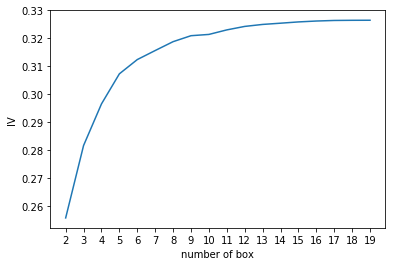

In [64]:
# 卡方检验，合并箱体，绘画iv曲线
num_bins_ = num_bins.copy()
IV = []
axisx = []

while len(num_bins_) > 2:
    pvs = []
    # 获取num_bins_ 两两之间的卡方检验的置信度
    for i in range(len(num_bins_) -1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0为chi2值 1为返回的p值
        pv = scipy.stats.chi2_contingency([x1, x2])[1]
        pvs.append(pv)
    # 通过p值进行处理，合并p值最大的两组
    i = pvs.index(max(pvs))
    # 将i和i+1项合并成一项
    num_bins_[i:i+2] = [(
        num_bins_[i][0], 
        num_bins_[i+1][1],
        num_bins_[i][2] + num_bins_[i+1][2],
        num_bins_[i][3] + num_bins_[i+1][3]
   )]

    axisx.append(len(num_bins_))
    # 计算woe和iv值
    woe_bins_df = get_woe(num_bins_)
    iv = get_iv(woe_bins_df)
    IV.append(iv)
plt.figure()
plt.plot(axisx, IV)
plt.xticks(axisx)
plt.xlabel('number of box')
plt.ylabel('IV')
plt.show()

In [67]:
x1 = num_bins_[0][2:]
x2 = num_bins_[1][2:]
# 0 代表卡方 1代表p值
temp = scipy.stats.chi2_contingency([x1, x2])
print(temp)
print(temp[0])
print(temp[1])

(11829.56204878175, 0.0, 1, array([[73163.25, 73092.75],
       [24387.75, 24364.25]]))
11829.56204878175
0.0


In [71]:
# 将上面合并分箱的代码封装成函数
def get_bin(num_bins_, n):
    while len(num_bins_) > n:
        pvs = []
        # 获取num_bins_ 两两之间的卡方检验的置信度
        for i in range(len(num_bins_) -1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            # 0为chi2值 1为返回的p值
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)
        # 通过p值进行处理，合并p值最大的两组
        i = pvs.index(max(pvs))
        # 将i和i+1项合并成一项
        num_bins_[i:i+2] = [(
            num_bins_[i][0], 
            num_bins_[i+1][1],
            num_bins_[i][2] + num_bins_[i+1][2],
            num_bins_[i][3] + num_bins_[i+1][3]
       )]
    return num_bins_

In [72]:
afterbins = get_bin(num_bins_, 4)
afterbins

[(21.0, 58.67420469903458, 62764, 83492),
 (58.67420469903458, 107.0, 34787, 13965)]

In [73]:
bins_df = get_woe(num_bins)
bins_df

,min,max,count_0,count_1,total,percentage,good%,bad%,woe
0,21.000000,28.000000,4222,5989,10211,0.052362,0.043280,0.061453,-0.350580
1,28.000000,31.170335,3497,5793,9290,0.047639,0.035848,0.059442,-0.505709
2,31.170335,34.000000,3999,6480,10479,0.053736,0.040994,0.066491,-0.483640
3,34.000000,36.793598,2904,6118,9022,0.046265,0.029769,0.062776,-0.746110
4,36.793598,39.000000,5156,5661,10817,0.055470,0.052854,0.058087,-0.094404
5,39.000000,41.000000,3966,5575,9541,0.048926,0.040656,0.057205,-0.341498
6,41.000000,43.000000,4029,5828,9857,0.050547,0.041301,0.059801,-0.370120
7,43.000000,45.000000,4443,5720,10163,0.052116,0.045545,0.058693,-0.253603
8,45.000000,47.000000,4769,6427,11196,0.057413,0.048887,0.065947,-0.299335
9,47.000000,48.489667,2468,4460,6928,0.035527,0.025300,0.045764,-0.592705


In [128]:
# 将选取最佳分箱个数的过程包装为函数
def graph_for_best_bin(df_, X, Y, n=5, q=20, graph=True):
    """
        自动最优分箱函数，基于卡方检验分箱
        参数：
        df：要输入的数据
        X：要分箱的列名
        Y：分箱数据对应的标签Y 列名 
        n：分箱个数
        q 初始分箱个数 
        graph 是否画出IV图像
    """
    df_ = df_[[X, Y]].copy()
    df_['qcut'], bins = pd.qcut(df_[X], retbins=True, q=q, duplicates='drop')
    count_y0 = df_[df_[Y] == 0].groupby(['qcut']).count()[Y]
    count_y1 = df_[df_[Y] == 1].groupby(['qcut']).count()[Y]
    num_bins = [*zip(bins, bins[1:], count_y0, count_y1)]

    # 合并分箱 如果一个分箱中只有一标签存在的话，合并
    # 首项出现这种情况，往后合并， 后面的再出现往前合并
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(num_bins[0][0], 
                              num_bins[1][1],
                              num_bins[0][2] + num_bins[1][2],
                              num_bins[0][3] + num_bins[1][3]
                             )]
            continue
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0], 
                    num_bins[i][1],
                    num_bins[i-1][2] + num_bins[i][2],
                    num_bins[i-1][3] + num_bins[i][3]
                )]
                break
        else:
            break
  

    #  计算woe
    def get_woe(num_bins):
        df = pd.DataFrame(num_bins, columns=['min', 'max', 'count_0', 'count_1'])
        df['total'] = df['count_0'] + df['count_1'] # 改分箱中的总数量
        df['percentage'] = df['total'] / df['total'].sum()
        df['good%'] = df['count_0'] / df['count_0'].sum()
        df['bad%'] = df['count_1'] / df['count_1'].sum()
        df['woe'] = np.log(df['good%'] / df['bad%'])
        return df

    # 计算iv值
    def get_iv(df):
        diff = df['good%']- df['bad%']
        iv = np.sum(diff * df['woe'])
        return iv
    
    
    IV = []
    axisx = []

    while len(num_bins) > n:
        pvs = []
        # 获取num_bins_ 两两之间的卡方检验的置信度
        for i in range(len(num_bins) -1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            # 0为chi2值 1为返回的p值
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)
        # 通过p值进行处理，合并p值最大的两组
        i = pvs.index(max(pvs))
        # 将i和i+1项合并成一项
        num_bins[i:i+2] = [(
            num_bins[i][0], 
            num_bins[i+1][1],
            num_bins[i][2] + num_bins[i+1][2],
            num_bins[i][3] + num_bins[i+1][3]
       )]

        axisx.append(len(num_bins))
        # 计算woe和iv值
        woe_bins_df = get_woe(num_bins)
        iv = get_iv(woe_bins_df)
        IV.append(iv)
        
    if graph:
        plt.figure()
        plt.plot(axisx, IV)
        plt.xticks(axisx)
        plt.xlabel('number of box')
        plt.ylabel('IV')
        plt.show()
    
    return woe_bins_df
    
    

In [129]:
model_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'qcut'],
      dtype='object')

RevolvingUtilizationOfUnsecuredLines


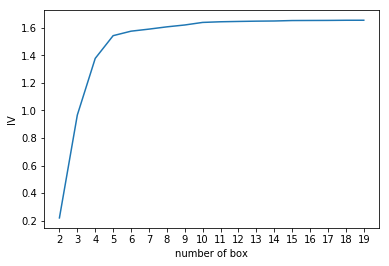

age


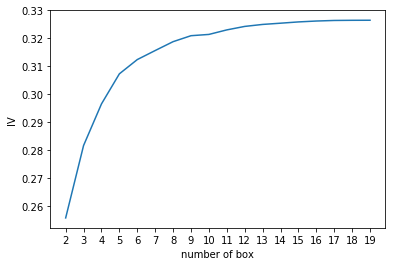

NumberOfTime30-59DaysPastDueNotWorse


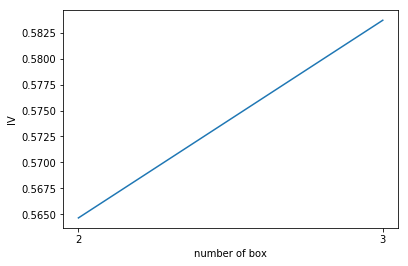

DebtRatio


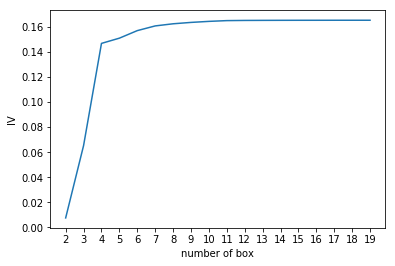

MonthlyIncome


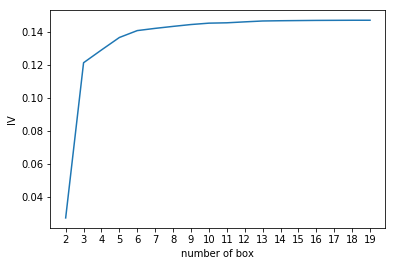

NumberOfOpenCreditLinesAndLoans


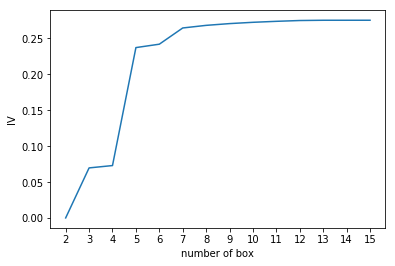

NumberOfTimes90DaysLate


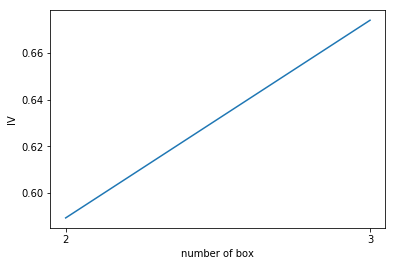

NumberRealEstateLoansOrLines


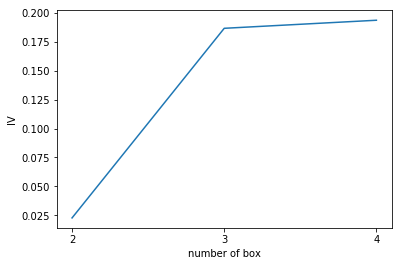

NumberOfTime60-89DaysPastDueNotWorse


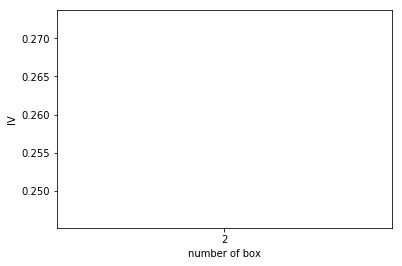

NumberOfDependents


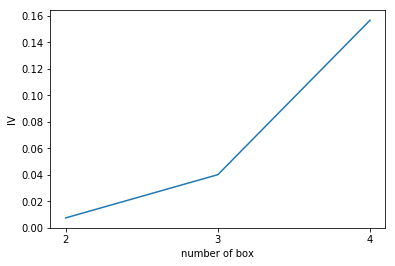

In [130]:
for i in model_data.columns[1:-1]:
    print(i)
    graph_for_best_bin(model_data, i, 'SeriousDlqin2yrs', n=2, q=20)

In [134]:
auto_col_bins = {'RevolvingUtilizationOfUnsecuredLines':6,
                'age':5,
                 'DebtRatio': 4,
                 'MonthlyIncome': 3,
                 'NumberOfOpenCreditLinesAndLoans': 5
                }

# 不能使用自动分箱的变量
hand_bins = {'NumberOfTime30-59DaysPastDueNotWorse': [0, 1, 2, 13],
            'NumberOfTimes90DaysLate': [0, 1, 2, 17],
             'NumberRealEstateLoansOrLines': [0, 1, 2, 4, 54],
             'NumberOfTime60-89DaysPastDueNotWorse': [0, 1, 2, 8],
             'NumberOfDependents': [0, 1, 2, 3]
            }
# 实际上就是添加上下无穷大的界限，把所有的数据都包括进去
hand_bins = {key:[-np.inf, *value[:-1], np.inf] for key, value in hand_bins.items()}
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [135]:
item = [1, 2, 3]
[*item[:-1]]

[1, 2]

In [138]:
bins_of_col = {}
# 生成自动分箱的分箱区间和分箱后的iv值
for col in auto_col_bins:  # 这样遍历是遍历字典的key值
    print('----' * 20)
    print(col)
    bins_df = graph_for_best_bin(model_data, 
                              col,
                              'SeriousDlqin2yrs',
                              n=auto_col_bins[col],
                              q=20,
                              graph=False
                             )
    print(bins_df)
    print('*****' * 5)
    # 取出min和max列 去重联合 在排序
    bins_list = sorted(set(bins_df['min']).union(bins_df['max']))
    print(set(bins_df['min']).union(bins_df['max']))
    # 把第一项和最后一项换成正负无穷大，使其能够包含所有的数据
    bins_list[0], bins_list[-1] = -np.inf, np.inf
    bins_of_col[col] = bins_list
    print(bins_list)


--------------------------------------------------------------------------------
RevolvingUtilizationOfUnsecuredLines
        min           max  count_0  count_1  total  percentage     good%  \
0  0.000000      0.060619    35900     3102  39002    0.200002  0.368013   
1  0.060619      0.220543    21685     7566  29251    0.149999  0.222294   
2  0.220543      0.551204    18308    20693  39001    0.199997  0.187676   
3  0.551204      0.982689    13905    44597  58502    0.299998  0.142541   
4  0.982689      1.000000     6324    10202  16526    0.084745  0.064828   
5  1.000000  29110.000000     1429    11297  12726    0.065259  0.014649   

       bad%       woe  
0  0.031829  2.447726  
1  0.077634  1.051992  
2  0.212330 -0.123421  
3  0.457607 -1.166382  
4  0.104682 -0.479196  
5  0.115918 -2.068526  
*************************
{0.0, 0.5512043523386752, 0.982689450393602, 0.22054267442946654, 0.06061851020000002, 0.9999999, 29110.0}
[-inf, 0.06061851020000002, 0.22054267442946654,

In [140]:
# 计算各箱的woe值并映射到数据中
data = model_data.copy()
# pd.cut, 可以根据已知的分箱间隔把数据分箱
data['cut'] = pd.cut(data['age'], 
                     [-np.inf, 48.489667249622286, 58.67420469903458, 64.0, 74.0, np.inf],
                    )
data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,qcut,cut
0,0,0.049337,53.000000,0.000000,805.000000,0.500000,12.000000,0.000000,1.000000,0.000000,0.000000,"(52.0, 54.0]","(48.49, 58.674]"
1,1,0.491558,44.543111,1.000000,0.327845,6045.913777,4.514370,0.000000,1.514370,0.514370,1.456889,"(43.0, 45.0]","(-inf, 48.49]"
2,0,0.005643,69.000000,0.000000,0.315537,5000.000000,9.000000,0.000000,1.000000,0.000000,1.000000,"(68.0, 74.0]","(64.0, 74.0]"
3,1,0.475414,32.620861,1.137418,0.779157,3800.000000,9.758279,0.000000,1.758279,0.000000,1.516558,"(31.17, 34.0]","(-inf, 48.49]"
4,1,0.257248,43.000000,0.000000,0.626258,10731.000000,7.000000,0.000000,4.000000,0.000000,4.000000,"(41.0, 43.0]","(-inf, 48.49]"
5,1,0.741127,42.059027,0.000000,0.174848,3098.411460,3.794270,0.000000,0.000000,0.735243,0.000000,"(41.0, 43.0]","(-inf, 48.49]"
6,0,0.000000,77.000000,0.000000,0.189431,4238.000000,8.000000,0.000000,1.000000,0.000000,0.000000,"(74.0, 107.0]","(74.0, inf]"
7,1,1.500896,27.209762,1.000000,591.104881,35.247164,4.000000,1.958048,0.000000,0.000000,0.000000,"(20.999, 28.0]","(-inf, 48.49]"
8,1,0.120109,54.188993,1.988188,0.535016,6200.000000,11.035436,0.000000,1.988188,0.988188,1.988188,"(54.0, 56.0]","(48.49, 58.674]"
9,1,0.703264,32.390025,0.000000,0.526170,8000.000000,11.402494,0.804987,0.597506,0.000000,1.195013,"(31.17, 34.0]","(-inf, 48.49]"


In [145]:
# 将数据按分箱结果聚合，并取出其中的标签值
data.groupby('cut')['SeriousDlqin2yrs'].value_counts()

cut              SeriousDlqin2yrs
(-inf, 48.49]    1                   58051
                 0                   39453
(48.49, 58.674]  1                   25441
                 0                   23311
(58.674, 64.0]   0                   13647
                 1                    7718
(64.0, 74.0]     0                   13381
                 1                    4738
(74.0, inf]      0                    7759
                 1                    1509
Name: SeriousDlqin2yrs, dtype: int64

In [146]:
# 使用unstack 把树状结构变成表结构
data.groupby('cut')['SeriousDlqin2yrs'].value_counts().unstack()

SeriousDlqin2yrs,0,1
cut,,
"(-inf, 48.49]",39453,58051
"(48.49, 58.674]",23311,25441
"(58.674, 64.0]",13647,7718
"(64.0, 74.0]",13381,4738
"(74.0, inf]",7759,1509


In [147]:
bins_df = data.groupby('cut')['SeriousDlqin2yrs'].value_counts().unstack()
bins_df['woe'] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 48.49]",39453,58051,-0.387176
"(48.49, 58.674]",23311,25441,-0.088401
"(58.674, 64.0]",13647,7718,0.569000
"(64.0, 74.0]",13381,4738,1.037257
"(74.0, inf]",7759,1509,1.636442
